### Loading Libs

In [1]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
import json

### Loding Different Files

In [2]:
model = joblib.load('voting_classifier_model.joblib')
encoders = joblib.load('encoders.joblib')
imputers = joblib.load("imputers.joblib")

In [3]:
df = pd.read_csv('netflix_customer_churn_with_nulls_labeled.csv')

In [4]:
df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,TV,8.99,churned,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Mobile,13.99,churned,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,TV,13.99,not churned,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,TV,17.99,churned,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Mobile,13.99,churned,Crypto,2,0.13,Action


### Preprocessing Data 

In [5]:
df = df.drop(columns = ['customer_id'])

In [6]:
df.head()

,age,gender,subscription_type,watch_hours,last_login_days,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,51,Other,Basic,14.73,29,TV,8.99,churned,Gift Card,1,0.49,Action
1,47,Other,Standard,0.70,19,Mobile,13.99,churned,Gift Card,5,0.03,Sci-Fi
2,27,Female,Standard,16.32,10,TV,13.99,not churned,Crypto,2,1.48,Drama
3,53,Other,Premium,4.51,12,TV,17.99,churned,Crypto,2,0.35,Horror
4,56,Other,Standard,1.89,13,Mobile,13.99,churned,Crypto,2,0.13,Action


In [7]:
df.isnull().sum()

age                         0
gender                      0
subscription_type         500
watch_hours                 0
last_login_days             0
device                    500
monthly_fee                 0
churned                     0
payment_method            500
number_of_profiles          0
avg_watch_time_per_day      0
favorite_genre              0
dtype: int64

In [8]:
imputed_df = df.copy()

for col, imputer in imputers.items():
    imputed_df[col] = imputer.transform(imputed_df[[col]]).ravel()


In [9]:
imputed_df.isnull().sum()

age                       0
gender                    0
subscription_type         0
watch_hours               0
last_login_days           0
device                    0
monthly_fee               0
churned                   0
payment_method            0
number_of_profiles        0
avg_watch_time_per_day    0
favorite_genre            0
dtype: int64

In [10]:
fin_df = imputed_df.copy()

for col, encoder in encoders.items():
    fin_df[col] = encoder.transform(fin_df[[col]])

In [11]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     5000 non-null   float64
 1   gender                  5000 non-null   float64
 2   subscription_type       5000 non-null   float64
 3   watch_hours             5000 non-null   float64
 4   last_login_days         5000 non-null   float64
 5   device                  5000 non-null   float64
 6   monthly_fee             5000 non-null   float64
 7   churned                 5000 non-null   float64
 8   payment_method          5000 non-null   float64
 9   number_of_profiles      5000 non-null   float64
 10  avg_watch_time_per_day  5000 non-null   float64
 11  favorite_genre          5000 non-null   float64
dtypes: float64(12)
memory usage: 468.9 KB


In [12]:
X = fin_df.drop(columns=["churned"])
y = fin_df["churned"]

In [13]:
print(model.named_estimators_)

{'lg_reg': LogisticRegression(max_iter=80), 'rdf': RandomForestClassifier(max_depth=8, min_samples_split=8, n_estimators=60,
                       random_state=42), 'gtb': GradientBoostingClassifier(learning_rate=0.5, max_depth=4,
                           min_samples_split=0.1, n_estimators=80,
                           random_state=42), 'knn': KNeighborsClassifier(n_neighbors=21), 'gnb': GaussianNB()}


In [14]:
gtb_model = model.named_estimators_['gtb']

In [15]:
X_background_data = X.sample(n=1100, random_state=0)

In [16]:
X_background_data

,age,gender,subscription_type,watch_hours,last_login_days,device,monthly_fee,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
398,22.0,2.0,2.0,1.04,56.0,0.0,13.99,4.0,3.0,0.02,1.0
3833,50.0,1.0,1.0,25.98,37.0,4.0,17.99,4.0,5.0,0.68,3.0
4836,19.0,1.0,1.0,3.28,30.0,4.0,17.99,1.0,5.0,0.11,3.0
4572,55.0,0.0,1.0,0.15,0.0,3.0,17.99,4.0,4.0,0.15,2.0
636,42.0,2.0,2.0,1.11,14.0,2.0,13.99,3.0,2.0,0.07,3.0
...,...,...,...,...,...,...,...,...,...,...,...
4628,28.0,0.0,1.0,16.69,47.0,2.0,17.99,2.0,3.0,0.35,5.0
1891,25.0,1.0,1.0,6.08,33.0,1.0,17.99,2.0,5.0,0.18,2.0
1814,56.0,2.0,0.0,1.62,8.0,4.0,8.99,0.0,1.0,0.18,6.0
230,68.0,0.0,2.0,2.70,35.0,3.0,13.99,2.0,1.0,0.08,2.0


### Initializaing Explainer

In [17]:
explainer = shap.Explainer(gtb_model,X_background_data,model_output="probability")

### Global Explainer

In [18]:
shap_val_global = explainer(X_background_data)
print("SHAP values shape:", shap_val_global.values.shape)
print("X shape:", X_background_data.shape)

SHAP values shape: (1100, 11)
X shape: (1100, 11)


In [19]:
class_labels = model.classes_
churn_index = list(class_labels).index(0)
non_churn_index = list(class_labels).index(1)

In [20]:
if shap_val_global.values.ndim == 3:
    shap_churn_global = shap_val_global.values[:, :, churn_index]
    shap_non_churn_global     = shap_val_global.values[:, :, non_churn_index]
else:
    shap_churn_global = shap_val_global.values
    shap_non_churn_global = -shap_val_global.values

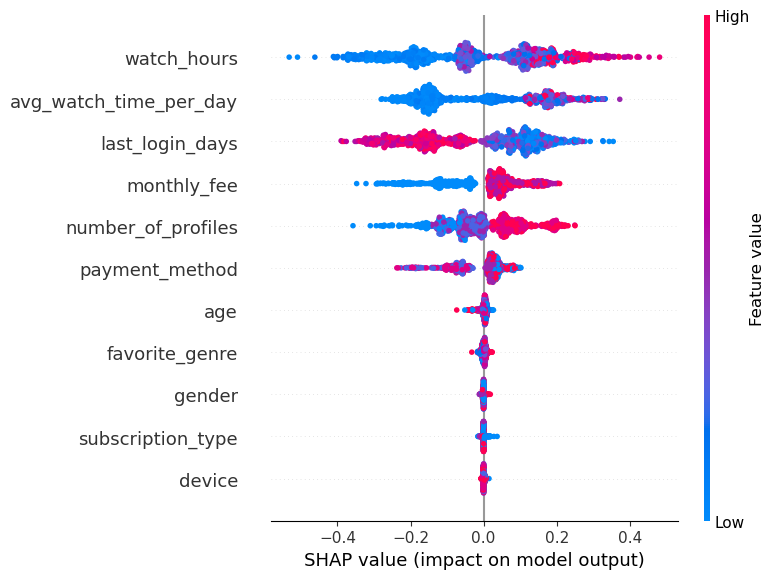

In [21]:
shap.summary_plot(shap_churn_global, X_background_data)

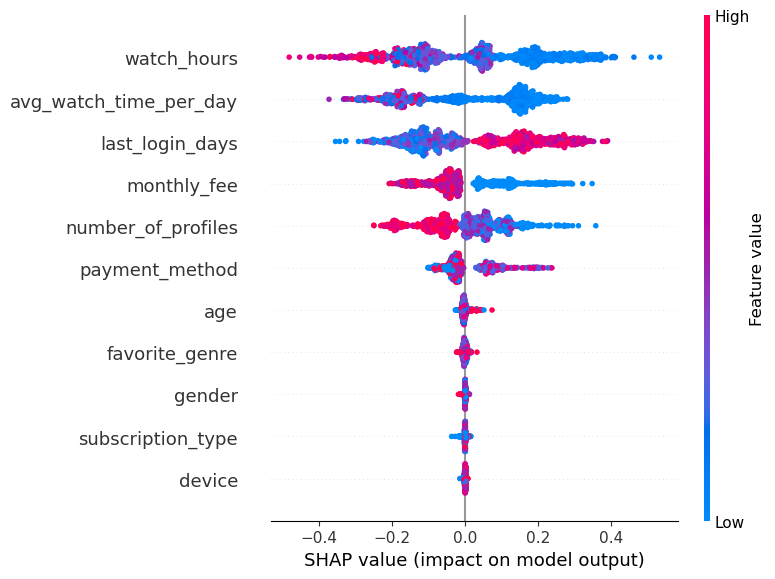

In [22]:
shap.summary_plot(shap_non_churn_global, X_background_data)

In [23]:
preds = model.predict(X)
churn_ind = np.where(preds == 0)[0]
high_risk_ind = churn_ind[0]
X_local = X.iloc[[high_risk_ind]]

### Local Explainer

In [24]:
shap_val_local = explainer(X_local)

if shap_val_local.values.ndim == 3:

    shap_churn_local = shap_val_local.values[0, :, churn_index]
    shap_non_churn_local = shap_val_local.values[0, :, non_churn_index]

else:
    shap_churn_local = shap_val_local.values[0]
    shap_non_churn_local = -shap_churn_local


print("SHAP values shape:", shap_val_local.values.shape)
print("X shape:", X_local.shape)

SHAP values shape: (1, 11)
X shape: (1, 11)


In [25]:
global_imp = pd.DataFrame({
    "feature": X_background_data.columns,
    "shap_value": shap_churn_global.mean(axis=0),
    "abs_shap_value": np.abs(shap_churn_global).mean(axis=0)
})

global_imp["direction"] = global_imp["shap_value"].apply(
    lambda x: "Increases churn risk" if x < 0 else "Reduces churn risk"
)

global_imp = global_imp.sort_values(
    by="abs_shap_value",
    ascending=False
)

global_top_features = global_imp["feature"].head(5).tolist()
global_imp.head(5)

,feature,shap_value,abs_shap_value,direction
3,watch_hours,-0.016509,0.165952,Increases churn risk
9,avg_watch_time_per_day,-0.017267,0.150453,Increases churn risk
4,last_login_days,-0.027511,0.145584,Increases churn risk
6,monthly_fee,0.005919,0.081496,Reduces churn risk
8,number_of_profiles,-0.002440,0.079377,Increases churn risk


In [26]:
local_imp = pd.DataFrame({
    "feature": X_local.columns,
    "shap_value": shap_churn_local
})

local_imp["abs_shap_value"] = local_imp["shap_value"].abs()

local_imp["direction"] = local_imp["shap_value"].apply(
    lambda x: "Increases churn risk" if x < 0 else "Reduces churn risk"
)

local_imp = local_imp.sort_values(
    by="abs_shap_value",
    ascending=False
)

local_top_features = local_imp["feature"].head(5).tolist()
local_imp.head(5)

,feature,shap_value,abs_shap_value,direction
6,monthly_fee,-0.229733,0.229733,Increases churn risk
8,number_of_profiles,-0.185166,0.185166,Increases churn risk
9,avg_watch_time_per_day,-0.133949,0.133949,Increases churn risk
7,payment_method,-0.096293,0.096293,Increases churn risk
4,last_login_days,0.076712,0.076712,Reduces churn risk


In [27]:
top_n = 5

global_top = global_imp.head(top_n).copy()

local_top = local_imp.set_index("feature")
local_top = local_top.loc[global_top["feature"]]
local_top = local_top.reset_index()

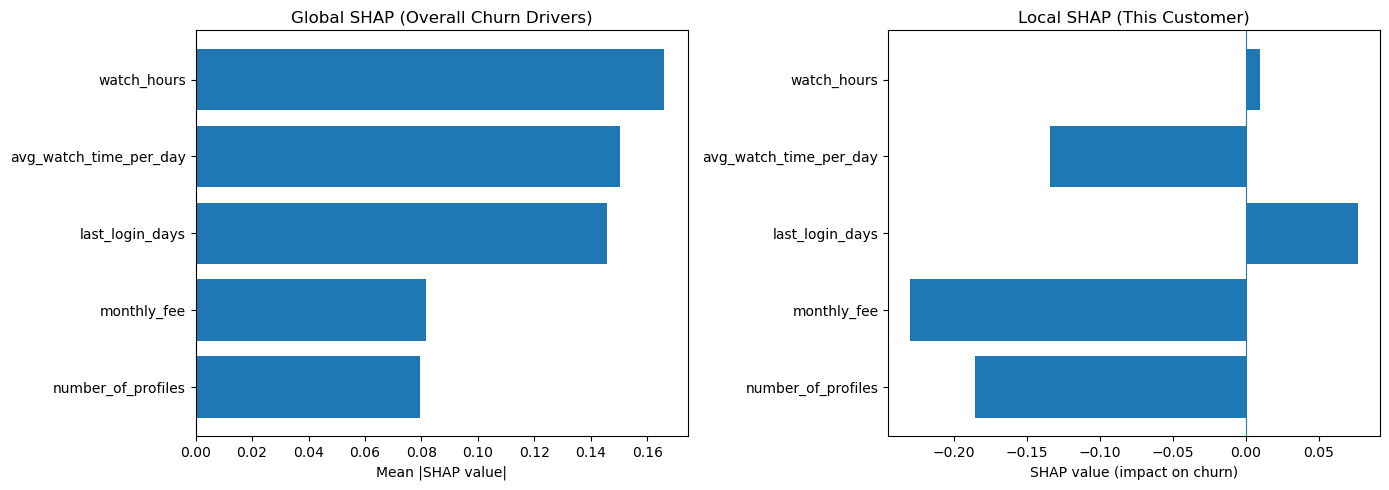

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# GLOBAL SHAP PLOT
axes[0].barh(
    global_top["feature"],
    global_top["abs_shap_value"]
)

axes[0].invert_yaxis()
axes[0].set_title("Global SHAP (Overall Churn Drivers)")
axes[0].set_xlabel("Mean |SHAP value|")

# LOCAL SHAP PLOT
axes[1].barh(
    local_top["feature"],
    local_top["shap_value"]
)

axes[1].axvline(0, linewidth=0.8)
axes[1].invert_yaxis()
axes[1].set_title("Local SHAP (This Customer)")
axes[1].set_xlabel("SHAP value (impact on churn)")

plt.tight_layout()
plt.show()

### Coverting SHAP Dataframe to JSON

In [29]:
def shap_in_json(local_importance, top_k=5):
    top_features = local_importance.head(top_k)

    shap_json = {
        "prediction": "Churn",
        "top_factors": []
    }

    for index, row in top_features.iterrows():

        impact_type = (
            "increases"
            if row["shap_value"] > 0
            else "reduces"
        )

        factor = {
            "feature": row["feature"],
            "impact": impact_type,
            "strength": round(float(row["abs_shap_value"]), 3)
        }

        shap_json["top_factors"].append(factor)

    return shap_json


In [30]:
shap_json = shap_in_json(local_imp)

In [31]:
print(json.dumps(shap_json, indent=4))

{
    "prediction": "Churn",
    "top_factors": [
        {
            "feature": "monthly_fee",
            "impact": "reduces",
            "strength": 0.23
        },
        {
            "feature": "number_of_profiles",
            "impact": "reduces",
            "strength": 0.185
        },
        {
            "feature": "avg_watch_time_per_day",
            "impact": "reduces",
            "strength": 0.134
        },
        {
            "feature": "payment_method",
            "impact": "reduces",
            "strength": 0.096
        },
        {
            "feature": "last_login_days",
            "impact": "increases",
            "strength": 0.077
        }
    ]
}


In [32]:
# X_background_data.to_csv("shap_background.csv",index = False)